# Protein Family Classification

## 1.1 Description

The directory contains data to train a model to predict the function of protein domains, based on the PFam dataset.

Domains are functional sub-parts of proteins; much like images in ImageNet are pre segmented to contain exactly one object class, this data is presegmented to contain exactly and only one domain.

The purpose of the dataset is to repose the PFam seed dataset as a multiclass classification machine learning task.

The task is: given the amino acid sequence of the protein domain, predict which class it belongs to. There are about 1 million training examples, and 18,000 output classes.

## Problem Statement:
<br>
Given the amino acid sequence of the protein domain, predict which class it belongs to. 

#### 1.2 Sources

https://www.kaggle.com/googleai/pfam-seed-random-split

## 2. Data Overview 

The approach used to partition the data into training/dev/testing folds is a random split.


*   Training data should be used to train your models.
*   Dev (development) data should be used in a close validation loop (maybe for hyperparameter tuning or model validation).
*  Test data should be reserved for much less frequent evaluations - this helps avoid overfitting on your test data, as it should only be used infrequently.





Each fold (train, dev, test) has a number of files in it. Each of those files contains csv on each line, which has the following fields:

*   sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE

*   family_accession: PF02953.15

*   sequence_name: C5K6N5_PERM5/28-87

*   aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 

*   family_id: zf-Tim10_DDP

#### Description of fields: - 

*   sequence: These are usually the input features to your model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z. 

*  family_accession: These are usually the labels for your model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.



*  family_id: One word name for family
* sequence_name: Sequence name, in the form "$uniprot_accession_id/$start_index-$end_index".


*   aligned_sequence: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.
*   Generally, the family_accession field is the label, and the sequence (or aligned sequence) is the training feature.

### 2.2.2 Performance Metric

Metric(s): Micro F1 score, Accuracy

source : [Mean F Score](https://www.kaggle.com/wiki/MeanFScore/history/120331)

## Exploratory Data Analysis

In [10]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
from Bio.SeqUtils import seq3
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from keras.datasets import mnist
import seaborn as sns
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Activation,Dense
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from sklearn.metrics import f1_score
from keras.preprocessing import sequence
max_review_length = 100
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

## Loading the data

In [11]:
data_partitions_dirpath = 'random_split/'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['dev', 'test', 'train']


In [12]:
#reading the files
def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [4]:
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Gly_kinase,Q07ZT2_SHEFN/3-383,PF02595.15,IVIAPDSFKESLSALEVANAIEDGFKQ......................,IVIAPDSFKESLSALEVANAIEDGFKQVFPNAQYCKVPMADGGEGT...
1,Pkinase_C,F2UES8_SALR5/486-527,PF00433.24,LKDPLDTSNF..DE.....DFTSLPAVDTPVE.................,LKDPLDTSNFDEDFTSLPAVDTPVEDSGLSQSVQRKFEGFSF
2,DUF3384,J9LUZ1_ACYPI/51-475,PF11864.8,IHTRIKAIKELAE.VAKSHR......LEENAVASLWLRVHD.LFSH...,IHTRIKAIKELAEVAKSHRLEENAVASLWLRVHDLFSHHVPKEDRH...
3,FKBP_N,F5YQG8_TREPZ/38-136,PF01346.18,DKDVGYAIGM....FIG.......SE.......................,DKDVGYAIGMFIGSEYKQQGQLSMITVDYDAFTRGFKDALEGNETA...
4,PAZ,PIWL2_XENTR/368-498,PF02170.22,LDIMNILYQ.................Q..SPEN...........FQ...,LDIMNILYQQSPENFQDEVTKQLVGSIVITRYNNRTYRIDDIEWNM...


In [0]:
print('There are {} output classes in train data'.format(train.family_accession.drop_duplicates().count()))
print('There are {} output classes in dev data'.format(dev.family_accession.drop_duplicates().count()))

There are 17929 output classes in train data
There are 13071 output classes in dev data


### Families with the most sequences

In [4]:
train.groupby('family_id').size().sort_values(ascending=False).head(10)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
dtype: int64

We can see that Methyltransf_25 is the most common family


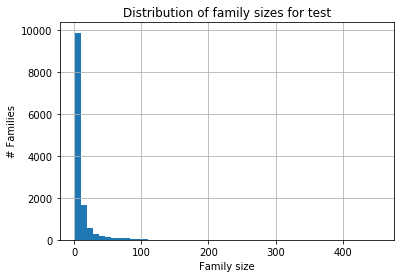

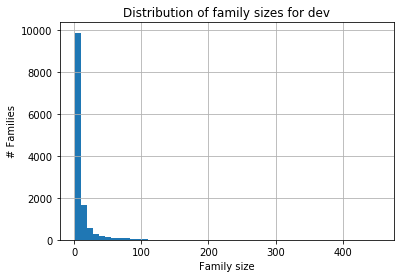

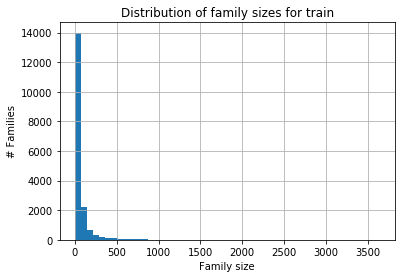

In [0]:
for name, partition in partitions.items():
    partition.groupby('family_id').size().hist(bins=50)
    plt.title('Distribution of family sizes for %s' % name)
    plt.ylabel('# Families')
    plt.xlabel('Family size')
    plt.show()

We can see that the train test and dev have same distribution.

### Families with the longest sequence length

Text(0, 0.5, 'Number of sequences')

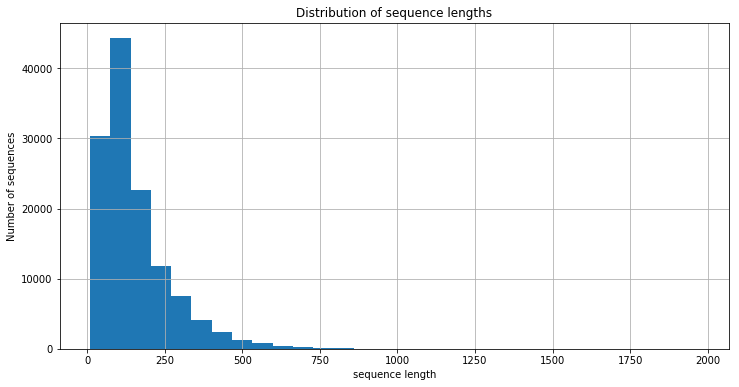

In [0]:
fig = plt.subplots(figsize=(12, 6))
dev['sequence'] = dev.sequence.str.len()
dev.sequence.hist(bins=30)
plt.title('Distribution of sequence lengths')
plt.xlabel('sequence length')
plt.ylabel('Number of sequences')

We can see that the average length of sequence is around 200

In [0]:
family_lengths = (dev[['family_id', 'sequence']]
                  .drop_duplicates()
                  .sort_values(by='sequence', ascending=False))

family_lengths.head(5)

,family_id,sequence
9434,GREB1,1971
6702,Nup192,1910
11512,Nup192,1855
7972,Nup192,1750
3109,Nup192,1676


The family GREB1 has the longest sequence of length 1971

In [0]:
family_lengths = (dev[['family_id', 'sequence']]
                  .drop_duplicates()
                  .sort_values(by='sequence', ascending=True))

family_lengths.head(5)

,family_id,sequence
5508,YLP,9
9947,LSPR,9
6021,Involucrin,9
6137,Sperm_act_pep,10
6137,FARP,10


The family GREB1 has the longest sequence of length 1971

### CDF of family accessions 

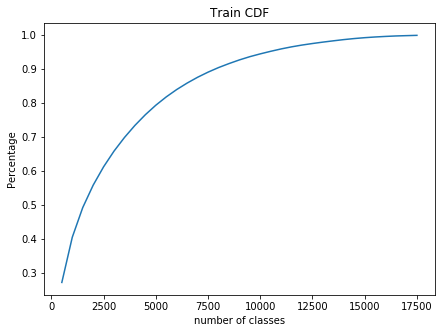

In [0]:
fig = plt.subplots(figsize=(7, 5))
train_range={}
for i in range(500,18000,500):
    train_top=train.groupby('family_id').size().sort_values(ascending=False).head(i)
    train_range[i]=train_top.values.sum()/1086741
plt.plot(train_range.keys(),train_range.values())
plt.xlabel('number of classes')
plt.ylabel('Percentage')
plt.title('Train CDF')
plt.show()

We consider only 1000 classes as it covers almost 40% of the data and also to reduce computation time

In [13]:
train_top=train.groupby('family_id').size().sort_values(ascending=False).head(1000)
print('1000 classes cover {}% of train data'.format(train_top.values.sum()/train.shape[0]*100))

1000 classes cover 40.44137471577864% of train data


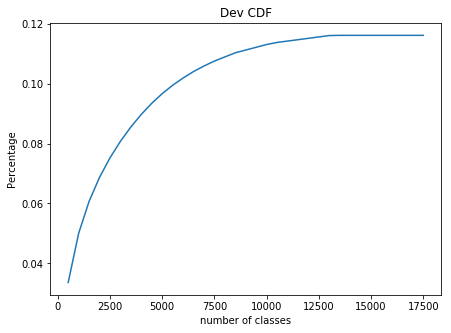

In [0]:
fig = plt.subplots(figsize=(7, 5))
dev_range={}
for i in range(500,18000,500):
    dev_top=dev.groupby('family_id').size().sort_values(ascending=False).head(i)
    dev_range[i]=dev_top.values.sum()/1086741
plt.plot(dev_range.keys(),dev_range.values())
plt.xlabel('number of classes')
plt.ylabel('Percentage')
plt.title('Dev CDF')
plt.show()

In [14]:
dev_top=dev.groupby('family_id').size().sort_values(ascending=False).head(800)

print('800 classes cover {}% of dev data'.format(dev_top.values.sum()/dev.shape[0]*100))

800 classes cover 38.251262175935835% of dev data


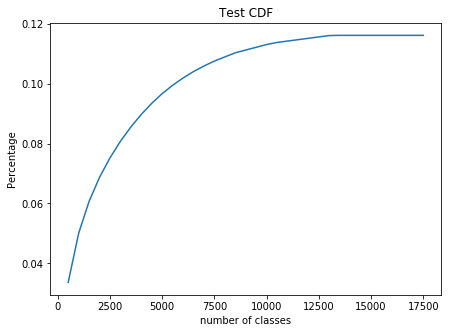

In [0]:
fig = plt.subplots(figsize=(7, 5))
test_range={}
for i in range(500,18000,500):
    test_top=dev.groupby('family_id').size().sort_values(ascending=False).head(i)
    test_range[i]=test_top.values.sum()/1086741
plt.plot(test_range.keys(),test_range.values())
plt.xlabel('number of classes')
plt.ylabel('Percentage')
plt.title('Test CDF')
plt.show()

We consider only 4500 classes as it covers 80% of the dev and test data

In [15]:
test_top=test.groupby('family_id').size().sort_values(ascending=False).head(800)

print('800 classes cover {}% of test data'.format(test_top.values.sum()/test.shape[0]*100))


800 classes cover 38.251262175935835% of test data


### Data Preprocessing

In [5]:
#function to get the input and output
def get_allocate_value(train_top,test_top,dev_top):
    train_list=train_top.index.tolist()
    test_list=test_top.index.tolist()
    dev_list=dev_top.index.tolist()
    x_train=train.loc[train['family_id'].isin(train_list)]
    x_test=test.loc[test['family_id'].isin(test_list)]
    x_dev=dev.loc[dev['family_id'].isin(dev_list)]
    y_train=x_train['family_accession'].values
    x_train=x_train['sequence']
    y_test=x_test['family_accession'].values
    x_test=x_test['sequence']

    y_dev=x_dev['family_accession'].values
    x_dev=x_dev['sequence']
    return x_train,x_test,x_dev,y_train,y_test,y_dev
 
#function to onehotencode the output    
def encode(y_train,y_test,y_dev):
    lb = LabelEncoder()
    y_train = lb.fit_transform(y_train)
    y_test=lb.transform(y_test)
    y_dev = lb.transform(y_dev)
    y_train=np.array(y_train)
    y_test=np.array(y_test)
    y_dev=np.array(y_dev)
    # Transform labels to one-hot
    lb = OneHotEncoder()
    y_train = lb.fit_transform(y_train.reshape(-1, 1))
    y_test=lb.transform(y_test.reshape(-1, 1))
    y_dev = lb.transform(y_dev.reshape(-1, 1))
    return y_train,y_test,y_dev

#function to convert the one letter amino acid into 3 letter and seperate them with a space
def preprocess(x_train,x_test,x_dev):
    preprocess_train=[]
    for i in tqdm(x_train.values):
        g=seq3(i)
        preprocess_train.append(' '.join([g[i:i+3] for i in range(0, len(g), 3)]))
      
    preprocess_test=[]
    for i in tqdm(x_test.values):
        e=seq3(i)
        preprocess_test.append(' '.join([e[i:i+3] for i in range(0, len(e), 3)]))

    preprocess_dev=[]
    for i in tqdm(x_dev.values):
        f=seq3(i)
        preprocess_dev.append(' '.join([f[i:i+3] for i in range(0, len(f), 3)]))
        
    return preprocess_train, preprocess_test, preprocess_dev

## One Hot Encoding

We will one hot encode the input sequence into L*20 array such that each column represents one hot encoding of each amino acid and padding with zeroes

In [8]:
#getting all the data

train_top=train.groupby('family_id').size().sort_values(ascending=False).head(1000)
dev_top=dev.groupby('family_id').size().sort_values(ascending=False).head(800)
test_top=test.groupby('family_id').size().sort_values(ascending=False).head(800)

x_train,x_test,x_dev,y_train,y_test,y_dev= get_allocate_value(train_top,test_top,dev_top)
y_train,y_test,y_dev=encode(y_train,y_test,y_dev)
preprocess_train, preprocess_test, preprocess_dev= preprocess(x_train,x_test,x_dev)

100%|██████████| 48262/48262 [00:03<00:00, 15736.93it/s]


In [9]:
# Fit one hot encoding on train set
l=[]
for g in tqdm(x_train):
    z=(' '.join([g[i:i+1] for i in range(0, len(g), 1)]))
    f=z.split()
    l.append(f)

corpus=[]
for x in l:
    for c in x:
        corpus.append(c)
        
lb = OneHotEncoder(sparse=False)
gg=lb.fit(np.array(corpus).reshape(-1, 1))

100%|██████████| 439493/439493 [00:15<00:00, 28881.03it/s]


In [12]:
#One hot encoding of train,test and dev set
c=0
train_encod=[]
dev_encod=[]
test_encod=[]
from tqdm.auto import tqdm
for train in tqdm(x_train):
    z=(' '.join([train[i:i+1] for i in range(0, len(train), 1)]))
    f=z.split()
    train_p=lb.transform(np.array(f).reshape(-1, 1))
    train_p=sequence.pad_sequences(train_p.T, maxlen=400,padding='post')
    train_p=train_p.T
    train_p=sequence.pad_sequences(train_p, maxlen=20)

      #gg=gg.T
    train_encod.append(train_p[:,:20].tolist())

for test in tqdm(x_test):
    z=(' '.join([test[i:i+1] for i in range(0, len(test), 1)]))
    f=z.split()
    test_p=lb.transform(np.array(f).reshape(-1, 1))
    test_p=sequence.pad_sequences(test_p.T, maxlen=400,padding='post')
    test_p=test_p.T
    test_p=sequence.pad_sequences(test_p, maxlen=20)
    test_encod.append(test_p[:,:20].tolist())
    
for dev in tqdm(x_dev):
    z=(' '.join([dev[i:i+1] for i in range(0, len(dev), 1)]))
    f=z.split()
    dev_p=lb.transform(np.array(f).reshape(-1, 1))
    dev_p=sequence.pad_sequences(dev_p.T, maxlen=400,padding='post')
    dev_p=dev_p.T
    dev_p=sequence.pad_sequences(dev_p, maxlen=20)
    dev_encod.append(dev_p[:,:20].tolist())
  #x_in=sequence.pad_sequences(x_in[0], maxlen=200)

In [38]:
print('The number of rows are:',len(train_encod[0]))
print('The number of columns are:',len(train_encod[0][0]))
print('The number of datapoints are:',len(train_encod))

The number of rows are: 400
The number of columns are: 20
The number of datapoints are: 439493


The input contains 439,493 lists with each list containing 400*20 shaped list corresponding to output variable 

In [13]:
output_dim=1000
input_dim=(100,20)
batch_size=64
epoch=1

In [12]:
#https://www.kaggle.com/meownoid/tiny-resnet-with-keras-99-314
#https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

from keras.layers import Dense, Conv1D
# example of a CNN model with an identity or projection residual module
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.utils import plot_model

# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv1D(n_filters, kernel_size=5, padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
  
    x=BatchNormalization()(layer_in)  
    x = Activation('relu')(x)
    #conv1
    conv1 = Conv1D(n_filters, kernel_size=5, padding='same', activation='relu', kernel_initializer='he_normal',dilation_rate=2)(x)
    x=BatchNormalization()(conv1)
  
    x = Activation('relu')(x)
    # conv2
    conv2 = Conv1D(n_filters,  kernel_size=5, padding='same', activation='linear', kernel_initializer='he_normal',dilation_rate=2)(x)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out


visible = Input(shape=(100,20))
x = Conv1D(kernel_size=3, filters=32, strides=1, padding='same')(visible)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = residual_module(x,128)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# dropout for more robust learning
x = Dropout(0.2)(x)
x=Flatten()(x)
# last softmax layer
x = Dense(units=1000)(x)
x = Activation('softmax')(x)

#layer = residual_module(x, 32)
model = Model(inputs=visible, outputs=x)

model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='residual_module.png')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 20)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 32)      1952        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 32)      128         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100, 32)      0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [14]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#compiling and fitting the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('best_model_one_hot.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# fit model

history = model.fit(np.array(train_encod),y_train,batch_size=128,epochs=15,verbose=1,validation_data=(np.array(dev_encod),y_dev), callbacks=[es, mc])


Train on 439493 samples, validate on 48262 samples
Epoch 1/15
439493/439493 [==============================] - 1235s 3ms/step - loss: 0.1795 - acc: 0.9650 - val_loss: 0.0651 - val_acc: 0.9852

Epoch 00001: val_acc improved from -inf to 0.98519, saving model to best_model_one_hot.h5
Epoch 2/15
439493/439493 [==============================] - 1238s 3ms/step - loss: 0.0170 - acc: 0.9963 - val_loss: 0.0719 - val_acc: 0.9856

Epoch 00002: val_acc improved from 0.98519 to 0.98560, saving model to best_model_one_hot.h5
Epoch 3/15
439493/439493 [==============================] - 1227s 3ms/step - loss: 0.0103 - acc: 0.9975 - val_loss: 0.0777 - val_acc: 0.9862

Epoch 00003: val_acc improved from 0.98560 to 0.98620, saving model to best_model_one_hot.h5
Epoch 4/15
439493/439493 [==============================] - 1225s 3ms/step - loss: 0.0072 - acc: 0.9982 - val_loss: 0.0701 - val_acc: 0.9870

Epoch 00004: val_acc improved from 0.98620 to 0.98701, saving model to best_model_one_hot.h5
Epoch 5/15
4

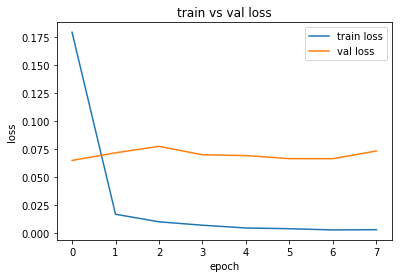

In [15]:
 #plotting train and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('train vs val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


In [16]:

# evaluate 
test_acc = model.evaluate(np.array(test_encod),y_test, verbose=0)

print('Test loss: %.3f' % ( test_acc[0]))
print(' Test accuracy: %.3f' % (test_acc[1]))


Test loss: 0.076
 Test accuracy: 0.988


In [17]:
test_pred=model.predict(np.array(test_encod))
print('f1 score is ',f1_score(np.argmax(test_pred, axis=1), np.argmax(y_test, axis=1),average='micro'))

f1 score is  0.9877957813600763


## k-mer Encoding 

In [0]:
#getting all the data

train_top=train.groupby('family_id').size().sort_values(ascending=False).head(1000)
dev_top=dev.groupby('family_id').size().sort_values(ascending=False).head(800)
test_top=test.groupby('family_id').size().sort_values(ascending=False).head(800)

x_train,x_test,x_dev,y_train,y_test,y_dev= get_allocate_value(train_top,test_top,dev_top)
y_train,y_test,y_dev=encode(y_train,y_test,y_dev)
preprocess_train, preprocess_test, preprocess_dev= preprocess(x_train,x_test,x_dev)

100%|██████████| 48262/48262 [00:02<00:00, 16511.98it/s]


In [0]:
x_train.head()

1    AGVPCSVKASEGYLFPLDRCFLFVTKPTLYIPYSEISSVVMSRTGG...
2    IRHVLMNSPPGKLYDLVKDINILLGSSVSIQKILEEVLKDYNEKNY...
3    MCIAIPGRIERIDYPIAIVDFKGLKKEVRIDLLENPQIGDYVLVHV...
4    NIFHILWEDVDLEGVTFKPMGESISVQGDIHIFVLYEGEGENTPIR...
5    VSPILQSLLDQLETTPAYILDQRMNIVGWNEAFSDVYGDYLYKGER...
Name: sequence, dtype: object

## MLP

#### Bigram

In [0]:
#Bigram vectorization
vectorizer = CountVectorizer(ngram_range=(0,2))
X_train = vectorizer.fit_transform(preprocess_train)
X_test = vectorizer.transform(preprocess_test)
X_dev = vectorizer.transform(preprocess_dev)
#print(vectorizer.get_feature_names())

In [201]:
X_train[0]

<1x434 sparse matrix of type '<class 'numpy.int64'>'
	with 70 stored elements in Compressed Sparse Row format>

In [0]:
X_test.shape

(101536, 537)

In [0]:
output_dim=1000
input_dim=491
batch_size=256
epoch=20

In [0]:
#building a model
model = Sequential()

model.add(Dense(512, input_dim=input_dim,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))

model.add(Dense(128,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.17, seed=None)))
model.add(Dense(1000,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               251904    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              65000     
Total params: 391,336
Trainable params: 391,080
Non-trainable params: 256
_________________________________________________________________


Train on 439493 samples, validate on 48262 samples
Epoch 1/20
439493/439493 [==============================] - 21s 48us/step - loss: 2.4501 - acc: 0.4631 - val_loss: 1.0182 - val_acc: 0.7444

Epoch 00001: val_acc improved from -inf to 0.74437, saving model to best_model_bow_bigram.h5
Epoch 2/20
439493/439493 [==============================] - 16s 37us/step - loss: 1.1906 - acc: 0.6938 - val_loss: 0.7759 - val_acc: 0.8006

Epoch 00002: val_acc improved from 0.74437 to 0.80063, saving model to best_model_bow_bigram.h5
Epoch 3/20
439493/439493 [==============================] - 17s 38us/step - loss: 0.9418 - acc: 0.7529 - val_loss: 0.6044 - val_acc: 0.8423

Epoch 00003: val_acc improved from 0.80063 to 0.84230, saving model to best_model_bow_bigram.h5
Epoch 4/20
439493/439493 [==============================] - 19s 42us/step - loss: 0.8146 - acc: 0.7839 - val_loss: 0.6140 - val_acc: 0.8391

Epoch 00004: val_acc did not improve from 0.84230
Epoch 5/20
439493/439493 [========================

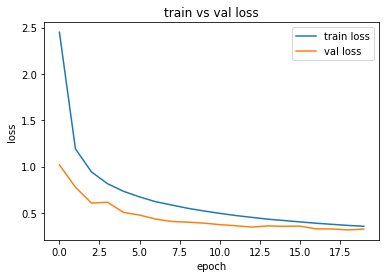

In [0]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#compiling and fitting the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_bow_bigram.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# fit model
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,verbose=1,validation_data=(X_dev,y_dev), callbacks=[es, mc])

# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('train vs val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
test_pred=model.predict(X_test)
print('f1 score is ',f1_score(np.argmax(test_pred, axis=1), np.argmax(y_test, axis=1),average='micro'))

f1 score is  0.9092660892627741


In [0]:
# load the saved model
#saved_model = load_model('best_model_bow_bigram.h5')
# evaluate the model
train_acc = model.evaluate(X_train,y_train, verbose=0)
test_acc = model.evaluate(X_test,y_test, verbose=0)
dev_acc = model.evaluate(X_dev,y_dev, verbose=0)
print('Train loss: %.3f, Test loss: %.3f, Dev loss : %3f' % (train_acc[0], test_acc[0],dev_acc[0]))
print('Train accuracy: %.3f, Test accuracy: %.3f, Dev accuracy : %3f' % (train_acc[1], test_acc[1],dev_acc[1]))



Train loss: 0.190, Test loss: 0.336, Dev loss : 0.324030
Train accuracy: 0.946, Test accuracy: 0.909, Dev accuracy : 0.911732


####  Trigram

In [0]:
#Trigram vectorization of the dataset
vectorizer = CountVectorizer(ngram_range=(1,3))
X_train = vectorizer.fit_transform(preprocess_train)
X_test = vectorizer.transform(preprocess_test)
X_dev = vectorizer.transform(preprocess_dev)

In [0]:
X_train.shape

(439493, 9085)

In [0]:
output_dim=1000
input_dim=9085
batch_size=256
epoch=20

In [0]:
#building the model

model = Sequential()

model.add(Dense(512, input_dim=input_dim,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))

model.add(Dense(128,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.17, seed=None)))
model.add(Dense(1000,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               4652032   
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              65000     
Total params: 4,791,464
Trainable params: 4,791,208
Non-trainable params: 256
________________________________________________________________

Train on 439493 samples, validate on 48262 samples
Epoch 1/20
439493/439493 [==============================] - 43s 99us/step - loss: 1.7611 - acc: 0.6335 - val_loss: 0.5084 - val_acc: 0.8712

Epoch 00001: val_acc improved from -inf to 0.87118, saving model to best_model_bow_trigram.h5
Epoch 2/20
439493/439493 [==============================] - 42s 95us/step - loss: 0.4523 - acc: 0.8790 - val_loss: 0.3579 - val_acc: 0.9069

Epoch 00002: val_acc improved from 0.87118 to 0.90692, saving model to best_model_bow_trigram.h5
Epoch 3/20
439493/439493 [==============================] - 42s 96us/step - loss: 0.2564 - acc: 0.9274 - val_loss: 0.3269 - val_acc: 0.9173

Epoch 00003: val_acc improved from 0.90692 to 0.91728, saving model to best_model_bow_trigram.h5
Epoch 4/20
439493/439493 [==============================] - 43s 97us/step - loss: 0.1723 - acc: 0.9486 - val_loss: 0.3217 - val_acc: 0.9211

Epoch 00004: val_acc improved from 0.91728 to 0.92110, saving model to best_model_bow_trigram.h5


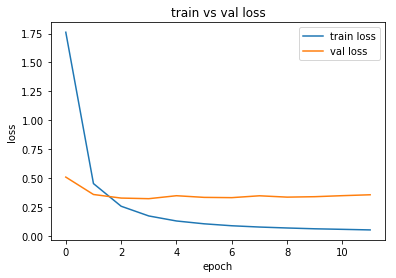

In [0]:
#compiling and fitting the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = ModelCheckpoint('best_model_bow_trigram.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# fit model
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,verbose=1,validation_data=(X_dev,y_dev), callbacks=[es, mc])

# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('train vs val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
#saved_model = load_model('best_model_bow_trigram.h5')
#train_pred=saved_model.predict(X_train)
test_pred=model.predict(X_test)
print('f1 score is ',f1_score(np.argmax(test_pred, axis=1), np.argmax(y_test, axis=1),average='micro'))

f1 score is  0.9308980150014504


In [0]:
# load the saved model

# evaluate the model
train_acc = model.evaluate(X_train,y_train, verbose=0)
test_acc = model.evaluate(X_test,y_test, verbose=0)
dev_acc = model.evaluate(X_dev,y_dev, verbose=0)
print('Train loss: %.3f, Test loss: %.3f, Dev loss : %3f' % (train_acc[0], test_acc[0],dev_acc[0]))
print('Train accuracy: %.3f, Test accuracy: %.3f, Dev accuracy : %3f' % (train_acc[1], test_acc[1],dev_acc[1]))


Train loss: 0.012, Test loss: 0.352, Dev loss : 0.355531
Train accuracy: 0.997, Test accuracy: 0.931, Dev accuracy : 0.930919


## LSTM


In [0]:
train_top=train.groupby('family_id').size().sort_values(ascending=False).head(1000)

dev_top=dev.groupby('family_id').size().sort_values(ascending=False).head(800)

test_top=test.groupby('family_id').size().sort_values(ascending=False).head(800)


In [0]:

x_train,x_test,x_dev,y_train,y_test,y_dev= get_allocate_value(train_top,test_top,dev_top)
y_train,y_test,y_dev=encode(y_train,y_test,y_dev)
preprocess_train, preprocess_test, preprocess_dev= preprocess(x_train,x_test,x_dev)

100%|██████████| 48262/48262 [00:03<00:00, 15777.79it/s]


In [0]:
vocab=[]

for sent in tqdm(preprocess_train):
    words=sent.split(" ")    
    vocab.append(words)
    
vocab_all=[]
for a in vocab:
    for x in a:
        vocab_all.append(x)
vocab_all=set(vocab_all)
# initialising all words with 0
vocabulary=dict([(x,0) for x in vocab_all])

100%|██████████| 439493/439493 [00:09<00:00, 47442.20it/s]


In [0]:
#counting the occurence of each word
count=0
for sent in tqdm(preprocess_train):
    
    words=sent.split(" ")
    
    for x in words:
        if x in vocabulary.keys():
            vocabulary[x]+=1

100%|██████████| 439493/439493 [00:27<00:00, 15911.86it/s]


In [0]:
vocabulary

{'Ala': 5988777,
 'Arg': 3609908,
 'Asn': 2433797,
 'Asp': 3576954,
 'Asx': 6,
 'Cys': 851185,
 'Gln': 2220574,
 'Glu': 4109154,
 'Gly': 5052648,
 'His': 1410422,
 'Ile': 4262868,
 'Leu': 6592761,
 'Lys': 3410226,
 'Met': 1510065,
 'Phe': 2698086,
 'Pro': 2779165,
 'Pyl': 1,
 'Sec': 7,
 'Ser': 3794491,
 'Thr': 3502984,
 'Trp': 790541,
 'Tyr': 2069051,
 'Val': 4916553,
 'Xaa': 410}

In [0]:
# converting into dataframe 
vocab_df= pd.DataFrame(list(vocabulary.items()), columns=['words', 'count'])
#sorting and getting the indices
vocab_df=vocab_df.sort_values(by='count',ascending=False)
top_vocab_df=vocab_df
top_vocab_df=top_vocab_df.reset_index()

vocab_dict={}
top_vocab_df.head()

,index,words,count
0,12,Leu,6592761
1,22,Ala,5988777
2,13,Gly,5052648
3,10,Val,4916553
4,21,Ile,4262868


In [0]:
#converting sentences to list of indexes
vocab_dict=dict(zip(top_vocab_df['words'],top_vocab_df.index))
count=0
all_words_list=[]
all_words_set=[]
train_vocab=[]
all_words_list=top_vocab_df['words'].tolist()
all_words_set=set(all_words_list)
for sent in tqdm(preprocess_train):
    sent_index=[]
   # print(sent)
    i=0
    word=sent.split(" ")
    
    for a in word:
        if a in all_words_set:
            sent_index.append(vocab_dict[a])
    train_vocab.append(sent_index)
    

100%|██████████| 439493/439493 [00:23<00:00, 18479.62it/s]


In [0]:
#similary converting dev and test into list of indices
dev_vocab=[]
for sent in tqdm(preprocess_dev):
    sent_index=[]
   # print(sent)
    i=0
    word=sent.split(" ")
    
    for a in word:
        if a in all_words_set:
            sent_index.append(vocab_dict[a])
    dev_vocab.append(sent_index)


test_vocab=[]
for sent in tqdm(preprocess_test):
    sent_index=[]
   # print(sent)
    i=0
    word=sent.split(" ")
    
    for a in word:
        if a in all_words_set:
            sent_index.append(vocab_dict[a])
    test_vocab.append(sent_index)

100%|██████████| 48262/48262 [00:04<00:00, 11200.25it/s]


In [0]:
#padding with 0

train_vocab = sequence.pad_sequences(train_vocab, maxlen=max_review_length)
test_vocab = sequence.pad_sequences(test_vocab, maxlen=max_review_length)
dev_vocab = sequence.pad_sequences(dev_vocab, maxlen=max_review_length)

In [0]:

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1000, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              101000    
Total params: 314,200
Trainable params: 314,200
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# fit model
history=model.fit(train_vocab, y_train, nb_epoch=15, batch_size=128,verbose=1,validation_data=(dev_vocab,y_dev),callbacks=[es, mc])


Train on 439493 samples, validate on 48262 samples
Epoch 1/15
439493/439493 [==============================] - 540s 1ms/step - loss: 2.8383 - acc: 0.4833 - val_loss: 1.1691 - val_acc: 0.7592

Epoch 00001: val_acc improved from -inf to 0.75917, saving model to best_model_lstm.h5
Epoch 2/15
439493/439493 [==============================] - 538s 1ms/step - loss: 0.8680 - acc: 0.8158 - val_loss: 0.5929 - val_acc: 0.8734

Epoch 00002: val_acc improved from 0.75917 to 0.87340, saving model to best_model_lstm.h5
Epoch 3/15
439493/439493 [==============================] - 536s 1ms/step - loss: 0.4799 - acc: 0.8950 - val_loss: 0.3742 - val_acc: 0.9176

Epoch 00003: val_acc improved from 0.87340 to 0.91764, saving model to best_model_lstm.h5
Epoch 4/15
439493/439493 [==============================] - 536s 1ms/step - loss: 0.3126 - acc: 0.9304 - val_loss: 0.2691 - val_acc: 0.9386

Epoch 00004: val_acc improved from 0.91764 to 0.93863, saving model to best_model_lstm.h5
Epoch 5/15
439493/439493 [==

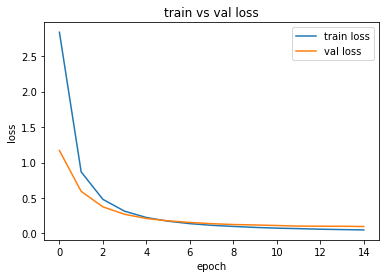

In [0]:
 #plotting train and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('train vs val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


In [0]:

# evaluate the model
train_acc = model.evaluate(train_vocab, y_train, verbose=0)
test_acc = model.evaluate(test_vocab,y_test, verbose=0)
dev_acc = model.evaluate(dev_vocab,y_dev, verbose=0)
print('Train loss: %.3f, Test loss: %.3f, Dev loss : %3f' % (train_acc[0], test_acc[0],dev_acc[0]))
print('Train accuracy: %.3f, Test accuracy: %.3f, Dev accuracy : %3f' % (train_acc[1], test_acc[1],dev_acc[1]))


Train loss: 0.041, Test loss: 0.102, Dev loss : 0.097211
Train accuracy: 0.991, Test accuracy: 0.973, Dev accuracy : 0.974245


In [0]:
# load the saved model
#saved_model = load_model('best_model_lstm.h5')
test_pred=model.predict(test_vocab)
print('f1 score is ',f1_score(np.argmax(test_pred, axis=1), np.argmax(y_test, axis=1),average='micro'))

f1 score is  0.9732501761220007


## Conclusion

Objective: Given the amino acid sequence of the protein domain, predict which class it belongs to.

1. We are given a dataset with  Train, Test and Dev files containing 1086741, 126171, 126171 rows and 5 columns: family_id, sequence_name,sequence,family_accession,aligned_sequence where family_accession is the output label consisting of 17929 classes and sequence is the input.
<br>
2. We visualize the train and test data and see that the train, test and dev have the same distribution, we perform data analysis and find the family with longest sequence length, most common family etc.
<br>
3. We see that the 1000 classes cover almost 40% of the dataset and also to reduce the time complexity, we only consider 1000 classes.
<br>
4. We take Recall and logloss as evaluation metric.
<br>
5.  We Preprocess the data and check for null values or duplicates and one hot encode the output class. We featurize the data using one hot encoding and converting into L*20 array where each column represents one hot encoding of each amino acid.
<br>
6. We also featurize the data using BoW bigrams and Trigrams since the input is a sequence of values and apply a mlp and find that both the models have similar accuracy of 93%.
<br>
7. We implement the protCNN model given in the paper using resnets. We use early stopping to avoid overfitting and save the models.
<br>
8. Since it is a sequence, we use LSTM model and consider only 1500 most common output classes due to huge training time and pass the indices as input to the model and the accuracy improved to 97%.
<br>
9. ProtCNN model gives the highest accuracy of 98.889%.


In [21]:
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=['Algorithm','ngram range','Vectorizor','F1 score','Train Accuracy','Dev Accuracy','Test Accuracy']

x.add_row(['PROTCNN','-','One Hot Encoding',0.987, 99.9, 98.9,98.8])
x.add_row(['MLP',2,'BoW',.909,94.6,91.1,90.9])
x.add_row(['MLP',3,'BoW', .9308,99.7,93.09,93.1])
x.add_row(['LSTM ','-','-',.973,99.1,97.4,97.3])

print(x)

+-----------+-------------+------------------+----------+----------------+--------------+---------------+
| Algorithm | ngram range |    Vectorizor    | F1 score | Train Accuracy | Dev Accuracy | Test Accuracy |
+-----------+-------------+------------------+----------+----------------+--------------+---------------+
|  PROTCNN  |      -      | One Hot Encoding |  0.987   |      99.9      |     98.9     |      98.8     |
|    MLP    |      2      |       BoW        |  0.909   |      94.6      |     91.1     |      90.9     |
|    MLP    |      3      |       BoW        |  0.9308  |      99.7      |    93.09     |      93.1     |
|   LSTM    |      -      |        -         |  0.973   |      99.1      |     97.4     |      97.3     |
+-----------+-------------+------------------+----------+----------------+--------------+---------------+
